In [1]:
import torch
import triton
import triton.language as tl
import my_cuda_ops

In [5]:
def softmax_cuda(x: torch.Tensor):
    # We need to preallocate the output.
    assert x.is_cuda
    output = torch.empty_like(x)
    # 创建输出张量
    my_cuda_ops.softmax(x, output, x.shape[0], x.shape[1])
    return output

In [3]:
# 本质就是一个block计算一行，
@triton.jit
def softmax_kernel(output_ptr, input_ptr, input_row_stride, output_row_stride, n_rows, n_cols, BLOCK_SIZE: tl.constexpr):
    row_len = 2 # 每个内核循环处理两行数据
    row_start = tl.program_id(0) * row_len
    if row_start >= n_rows: # 行的mask
        return
    for row_idx in tl.range(row_start, row_start + row_len, 1):
        # The stride represents how much we need to increase the pointer to advance 1 row
        # 步长表示我们需要对指针增加多少以推进 1 行
        row_start_ptr = input_ptr + row_idx * input_row_stride
        # The block size is the next power of two greater than n_cols, so we can fit each
        # 块大小是大于 n_cols 的下一个二的幂，因此我们可以适配
        # row in a single block
        # 单个块中的行
        col_offsets = tl.arange(0, BLOCK_SIZE)
        input_ptrs = row_start_ptr + col_offsets
        # Load the row into SRAM, using a mask since BLOCK_SIZE may be > than n_cols
        # 将行加载到 SRAM 中，使用掩码，因为 BLOCK_SIZE 可能大于 n_cols
        mask = col_offsets < n_cols
        row = tl.load(input_ptrs, mask=mask, other=-float('inf'))
        # Subtract maximum for numerical stability
        # 为了数值稳定性而减去最大值
        row_minus_max = row - tl.max(row, axis=0)
        # Note that exponentiation in Triton is fast but approximate (i.e., think __expf in CUDA)
        # 请注意，Triton 中的指数运算速度很快，但是是近似的（例如，类似于 CUDA 中的 __expf）。
        numerator = tl.exp(row_minus_max)
        denominator = tl.sum(numerator, axis=0)
        softmax_output = numerator / denominator
        # Write back output to DRAM
        # 将输出写回 DRAM
        output_row_start_ptr = output_ptr + row_idx * output_row_stride
        output_ptrs = output_row_start_ptr + col_offsets
        tl.store(output_ptrs, softmax_output, mask=mask)

def softmax_triton(input_tensor: torch.Tensor):
    output_tensor = torch.empty_like(input_tensor)  # 用于存储输出的张量

    # 2. 定义 kernel 的网格和块大小
    n_rows, n_cols = input_tensor.shape
    BLOCK_SIZE = triton.next_power_of_2(n_cols)  # 计算大于 n_cols 的下一个 2 的幂
    num_stages = 3  # 可以根据硬件调整

    # 3. 调用 kernel
    grid = lambda meta: (triton.cdiv(n_rows, 2),)  # 网格大小为行数
    softmax_kernel[grid](
        output_tensor, input_tensor,
        input_tensor.stride(0), output_tensor.stride(0),  # 行步长
        n_rows, n_cols,
        BLOCK_SIZE=BLOCK_SIZE,
    )
    return output_tensor

In [7]:
torch.manual_seed(0)
size = (2048,512)
x = torch.rand(size, device='cuda')
y = torch.rand(size, device='cuda')
output_torch = torch.softmax(x, dim=1)
output_triton = softmax_triton(x)
output_cuda = softmax_cuda(x)
print(output_torch)
print(output_triton)
print(output_cuda)
print(f'The maximum difference between torch and triton is '
      f'{torch.max(torch.abs(output_torch - output_triton))}')
print(f'The maximum difference between torch and cuda is '
      f'{torch.max(torch.abs(output_torch - output_cuda))}')

tensor([[0.0017, 0.0019, 0.0011,  ..., 0.0024, 0.0015, 0.0023],
        [0.0020, 0.0015, 0.0015,  ..., 0.0013, 0.0018, 0.0031],
        [0.0020, 0.0022, 0.0013,  ..., 0.0031, 0.0017, 0.0024],
        ...,
        [0.0015, 0.0014, 0.0024,  ..., 0.0027, 0.0023, 0.0013],
        [0.0012, 0.0022, 0.0013,  ..., 0.0015, 0.0025, 0.0016],
        [0.0026, 0.0027, 0.0027,  ..., 0.0017, 0.0025, 0.0018]],
       device='cuda:0')
tensor([[0.0017, 0.0019, 0.0011,  ..., 0.0024, 0.0015, 0.0023],
        [0.0020, 0.0015, 0.0015,  ..., 0.0013, 0.0018, 0.0031],
        [0.0020, 0.0022, 0.0013,  ..., 0.0031, 0.0017, 0.0024],
        ...,
        [0.0015, 0.0014, 0.0024,  ..., 0.0027, 0.0023, 0.0013],
        [0.0012, 0.0022, 0.0013,  ..., 0.0015, 0.0025, 0.0016],
        [0.0026, 0.0027, 0.0027,  ..., 0.0017, 0.0025, 0.0018]],
       device='cuda:0')
tensor([[0.0017, 0.0019, 0.0011,  ..., 0.0024, 0.0015, 0.0023],
        [0.0020, 0.0015, 0.0015,  ..., 0.0013, 0.0018, 0.0031],
        [0.0020, 0.0022, 0.0

In [8]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['size'],  # Argument names to use as an x-axis for the plot.
        x_vals=[2**i for i in range(9, 15, 1)],  # Different possible values for `x_name`.
        x_log=True,  # x axis is logarithmic.
        line_arg='provider',  # Argument name whose value corresponds to a different line in the plot.
        line_vals=['triton', 'torch', 'cuda'],  # Possible values for `line_arg`.
        line_names=['Triton', 'Torch', 'CUDA'],  # Label name for the lines.
        styles=[('blue', '-'), ('green', '-'), ('red', '-')],  # Line styles.
        ylabel='GB/s',  # Label name for the y-axis.
        plot_name='vector-add-performance',  # Name for the plot. Used also as a file name for saving the plot.
        args={},  # Values for function arguments not in `x_names` and `y_name`.
    ))
def benchmark(size, provider):
    x = torch.rand((size, 512), device='cuda', dtype=torch.float32)
    quantiles = [0.5, 0.2, 0.8]
    if provider == 'torch':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: torch.softmax(x, dim=1), quantiles=quantiles)
    if provider == 'triton':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: softmax_triton(x), quantiles=quantiles)
    if provider == 'cuda':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: softmax_cuda(x), quantiles=quantiles)
    gbps = lambda ms : 3 * x.numel() * x.element_size() * 1e-9 / (ms * 1e-3)
    return gbps(ms), gbps(max_ms), gbps(min_ms)

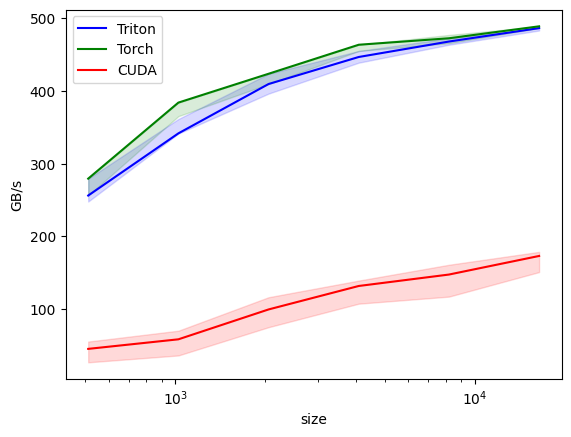

vector-add-performance:
      size      Triton       Torch        CUDA
0    512.0  255.999991  279.272725   44.785418
1   1024.0  341.629877  384.000001   57.953724
2   2048.0  409.600010  423.724127   99.096776
3   4096.0  446.836360  463.698115  131.422461
4   8192.0  468.114289  472.615390  147.161672
5  16384.0  486.653476  489.074621  172.766249


In [9]:
benchmark.run(print_data=True, show_plots=True)